In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
import sklearn.linear_model

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

In [2]:
sp500_downloaded = pd.read_csv('/content/drive/MyDrive/stock_market_data_2023.csv', index_col = 0)
sp500_downloaded.index = pd.to_datetime(sp500_downloaded.index)

In [ ]:
sp500_downloaded

In [5]:
#Looking at too much data would make the model more inaccurate.
#The market changes over time and the market shift would make old data worsen the model
#To prevent this, data from after 1990 is taken

specificDate = pd.to_datetime("1990-01-01").date()
sp500_downloaded = sp500_downloaded.loc[specificDate:].copy()

#Deleting these columns from the data frame as they are for individual stocks and not required to index
del sp500_downloaded["Dividends"]
del sp500_downloaded["Stock Splits"]

# creating a column that shows the next day's closing price
sp500_downloaded["Tomorrow"] = sp500_downloaded["Close"].shift(-1)
# creating the target column that uses the "Tomorrow" column to see if the price increases the next day
sp500_downloaded["Target"] = (sp500_downloaded["Tomorrow"] > sp500_downloaded["Close"]).astype(int)

# Setting up the initial ML model

Using a random forest classifier to predict whether the stock price would increase.

Using random forest because they are more resistant to overfitting than most models, run quick and pick up non-linear tendencies in the data.

Picking up non-linearity is important for our data. A higher closing price than from a year ago doesn't mean the target will also be higher, the target could be 0, implying non-linearity.

In [7]:
# Creating a random forest with 500 decision trees ('n_estimators')
model = RandomForestClassifier(n_estimators=500, min_samples_split=100, random_state=1)

# Creating a test set of the last 100 items
train = sp500_downloaded.iloc[:-100]
test = sp500_downloaded.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=500, random_state=1)

In [8]:
# Generating predictions on the test set and converting into a pandas series
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [9]:
# Calculating precision score by comparing our predictions with the target of the test set
precision_score(test["Target"], preds)

0.5172413793103449

<Axes: >

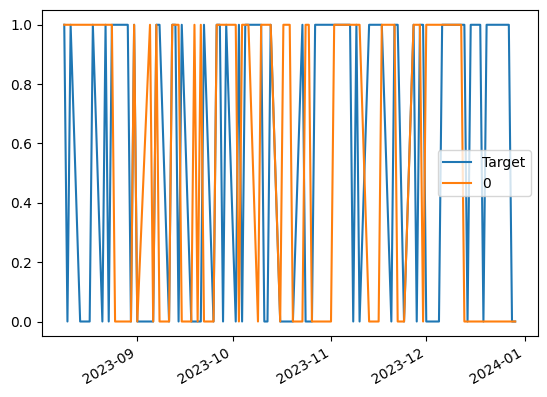

In [10]:
combined = pd.concat([test["Target"], preds], axis=1)
# The orange line signifies our model's predictions and the blue line is the actual data.
combined.plot()

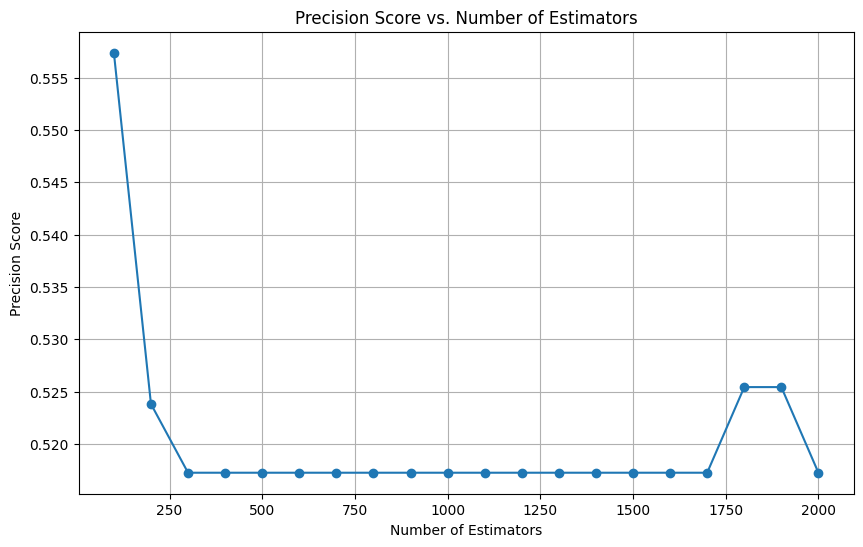

In [11]:

# Define the range of n_estimators values
estimator_range = range(100, 2100, 100)

# Initialize lists to store precision scores
precision_scores = []

# Loop through different values of n_estimators
for n_estimators in estimator_range:
    # Create and fit the model
    model = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=100, random_state=1)
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict(test[predictors])

    # Calculate precision score and append to the list
    precision = precision_score(test["Target"], preds)
    precision_scores.append(precision)

# Plot precision scores against n_estimators
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, precision_scores, marker='o')
plt.title('Precision Score vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Precision Score')
plt.grid(True)
plt.show()


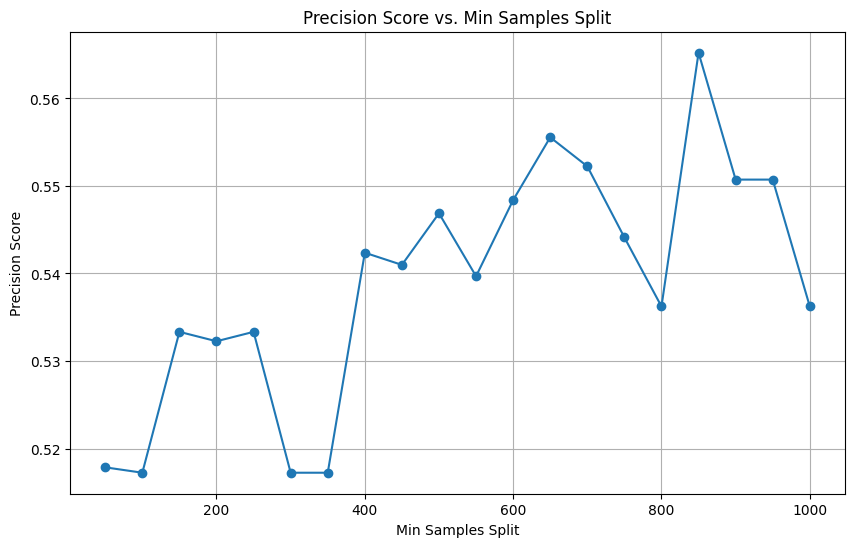

In [12]:

# Define the range of min_samples_split values
min_samples_split_range = range(50, 1001, 50)

# Initialize lists to store precision scores
precision_scores = []

# Loop through different values of min_samples_split
for min_samples_split in min_samples_split_range:
    # Create and fit the model
    model = RandomForestClassifier(n_estimators=500, min_samples_split=min_samples_split, random_state=1)
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict(test[predictors])

    # Calculate precision score and append to the list
    precision = precision_score(test["Target"], preds)
    precision_scores.append(precision)

# Plot precision scores against min_samples_split
plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_range, precision_scores, marker='o')
plt.title('Precision Score vs. Min Samples Split')
plt.xlabel('Min Samples Split')
plt.ylabel('Precision Score')
plt.grid(True)
plt.show()

In [13]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def predict(train, test, predictors, model):
    # Fit the model on the training data
    model.fit(train[predictors], train["Target"])

    # Make predictions on the test data
    preds = model.predict(test[predictors])

    # Create a Series of predictions with index from the test data
    preds = pd.Series(preds, index=test.index, name="Predictions")

    # Combine the actual target values and the predictions into a DataFrame
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [14]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    # Iterate through the data with a given start index and step size
    for i in range(start, data.shape[0], step):
        # Create train and test sets based on the current index and step size
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Generate predictions for the current test set using the predict function
        predictions = predict(train, test, predictors, model)

        # Append the predictions to the list
        all_predictions.append(predictions)

    # Concatenate all the predictions into a single DataFrame and return it
    return pd.concat(all_predictions)

In [15]:
predictions = backtest(sp500_downloaded, model, predictors)

In [16]:
predictions["Predictions"].value_counts()

1    3334
0    2731
Name: Predictions, dtype: int64

In [17]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5320935812837433